*Made by Artem Vazhentsev (AIRI)*

In [ ]:
from IPython.display import display, clear_output

import numpy as np
import pandas as pd
from tqdm.notebook import tqdm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import Dataset, DataLoader

In [ ]:
!wget  -O 'housing_data.csv' -q 'https://www.dropbox.com/s/6dxq90t0prn2vaw/_train_sem2.csv?dl=0'

In [ ]:
!pip install transformers
!pip install datasets

In [ ]:
df = pd.read_csv('housing_data.csv')
print(df.shape)
df.head()

(1460, 81)


,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,...,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,...,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [ ]:
data = df.select_dtypes(['int64', 'float64'])
data.head()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,...,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
0,1,60,65.0,8450,7,5,2003,2003,196.0,706,...,0,61,0,0,0,0,0,2,2008,208500
1,2,20,80.0,9600,6,8,1976,1976,0.0,978,...,298,0,0,0,0,0,0,5,2007,181500
2,3,60,68.0,11250,7,5,2001,2002,162.0,486,...,0,42,0,0,0,0,0,9,2008,223500
3,4,70,60.0,9550,7,5,1915,1970,0.0,216,...,0,35,272,0,0,0,0,2,2006,140000
4,5,60,84.0,14260,8,5,2000,2000,350.0,655,...,192,84,0,0,0,0,0,12,2008,250000


In [ ]:
X = data.drop(columns=['Id', 'SalePrice']).fillna(data.mean()).values.astype(np.float32)
y = data.SalePrice.values.astype(np.float32)

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

In [ ]:
ss = StandardScaler()
X_train = ss.fit_transform(X_train)
X_test = ss.transform(X_test)

In [ ]:
ss2 = StandardScaler()
y_train = ss2.fit_transform(y_train[:, None]).reshape(-1)
y_test = ss2.transform(y_test[:, None]).reshape(-1)

In [ ]:
# Constants
SEED = 42 # random seed for reproducibility
LR = 3e-2 # learning rate, controls the speed of the training
WEIGHT_DECAY = 1e-3 # lambda for L2 reg. ()
NUM_EPOCHS = 5 # num training epochs (how many times each instance will be processed)
GAMMA = 0.9995 # learning rate scheduler parameter
BATCH_SIZE = 64 # training batch size
EVAL_BATCH_SIZE = 300 # evaluation batch size.
DEVICE = 'cpu' #'cuda' # device to make the calculations on

In [ ]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.2, random_state = SEED)

In [ ]:
# Initialize the DataObject, which must return an element (features vector x and target value y)
# for a given idx. This class must also have a length atribute
class MyDataset(Dataset):
    def __init__(self, X, y):
        super().__init__() # to initialize the parent class
        self.X = X
        self.y = y
        self.len = len(X)

    def __len__(self): # We use __func__ for implementing in-built python functions
        return self.len

    def __getitem__(self, index):
        return self.X[index], self.y[index]

In [ ]:
# Initialize DataLoaders - objects, which sample instances from DataObject-s
train_dl = DataLoader(
    MyDataset(X_train, y_train),
    batch_size = BATCH_SIZE,
    shuffle = True
)

val_dl = DataLoader(
    MyDataset(X_val, y_val),
    batch_size = EVAL_BATCH_SIZE,
    shuffle = False
)

test_dl = DataLoader(
    MyDataset(X_test, y_test),
    batch_size = EVAL_BATCH_SIZE,
    shuffle = False
)

dls = {'train': train_dl, 'val': val_dl, 'test': test_dl}

In [ ]:
#add a new layer in the model, which will be modified further
class Model(nn.Module):
    def __init__(self, in_features = 36, out_features = 1, hidden_size_2 = 128):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_size = int(np.sqrt(in_features + out_features))
        self.hidden_size_2 = hidden_size_2

        self.sequential = nn.Sequential( # NN architecure, where the modules modify the data sequentially
            nn.Linear(in_features, self.hidden_size), # Linear transformation
            nn.ReLU(), # Activation function 
            nn.Linear(self.hidden_size, self.hidden_size_2), # Linear transformation
            nn.ReLU(), # Activation function 
            nn.Linear(self.hidden_size_2, self.out_features) # Another Linear transformation
        )

    def forward(self, x): # In the forward function, you define how your model runs, from input to output 
        x = self.sequential(x)
        return x

In [ ]:
torch.manual_seed(SEED) # Fix random seed to have reproducible weights of model layers

model = Model()
model.to(DEVICE)

loss_fn = nn.MSELoss() # Loss function, which our model will try to minimize
# Initialize GD method, which will update the weights of the model
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
# Initialize learning rate scheduler, which will decrease LR according to some rule
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

In [ ]:
# Training loop
metrics_dict = {
    "Epoch": [],
    "Train RMSE": [],
    "Val RMSE": [],
}

# Train loop
for epoch in tqdm(range(NUM_EPOCHS)):
    metrics_dict["Epoch"].append(epoch)
    for stage in ['train', 'val']:
        with torch.set_grad_enabled(stage == 'train'): # Whether to start building a graph for a backward pass
            if stage == 'train':
                model.train() # Enable some "special" layers (will speak about later)
            else:
                model.eval() # Disable some "special" layers (will speak about later)

            loss_at_stage = 0 
            for batch in dls[stage]:
                x_batch, y_batch = batch
                x_batch, y_batch = x_batch.to(DEVICE), y_batch.to(DEVICE)

                y_pred = model(x_batch).view(-1) # forward pass: model(x_batch) -> calls forward()
                loss = loss_fn(y_pred, y_batch) # ¡Important! y_pred is always the first arg
                if stage == "train":
                    loss.backward() # Calculate the gradients of all the parameters wrt loss
                    optimizer.step() # Update the parameters
#                     scheduler.step()
                    optimizer.zero_grad() # Zero the saved gradient
                with torch.no_grad():
                    loss_at_stage += (torch.square((y_pred - y_batch)).sum()).item()
            rmse_at_stage = (loss_at_stage / len(dls[stage].dataset)) ** (1/2)
            metrics_dict[f"{stage.title()} RMSE"].append(rmse_at_stage)
            
    clear_output(wait=True)
    display(pd.DataFrame(metrics_dict))

,Epoch,Train RMSE,Val RMSE
0,0,0.700999,0.435212
1,1,0.579868,0.742594
2,2,0.556940,0.444957
3,3,0.466360,0.406746
4,4,0.449903,0.421571


# HuggingFace Trainer



In [ ]:
from transformers import TrainingArguments, Trainer, set_seed
from sklearn.metrics import mean_squared_error

#define all hyperparameters in one object TrainingArguments
training_args = TrainingArguments(output_dir="test_trainer", 
                                  evaluation_strategy="epoch",
                                  logging_strategy="epoch",
                                  seed=SEED,
                                  learning_rate=LR,
                                  weight_decay=WEIGHT_DECAY,
                                  num_train_epochs=NUM_EPOCHS,
                                  per_device_train_batch_size=BATCH_SIZE,
                                  per_device_eval_batch_size=EVAL_BATCH_SIZE,
                                  label_names=["labels"],
                                  report_to="none",)

#define custom trainer for computing MSE loss
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False):
        y_true = inputs.get(self.label_names[0])
        x = inputs.get("x")
        # forward pass
        y_preds = model(x).view(-1)
        loss = loss_fn(y_preds, y_true)
        return (loss, {"y_preds": y_preds}) if return_outputs else loss

def compute_metrics(eval_preds):
    y_preds, y_true = eval_preds
    y_preds_rescheduled = y_preds * ss2.scale_ + ss2.mean_
    y_true_rescheduled = y_true * ss2.scale_ + ss2.mean_
    rmse = mean_squared_error(y_true_rescheduled, y_preds_rescheduled, squared=False)
    return {"RMSE": rmse}

In [ ]:
from datasets import Dataset

train_ds = Dataset.from_dict({'x': X_train, 'labels': y_train})
eval_ds = Dataset.from_dict({'x': X_val, 'labels': y_val})
test_ds = Dataset.from_dict({'x': X_test, 'labels': y_test})

In [ ]:
model = Model()
model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler)
)

trainer.train()

***** Running training *****
  Num examples = 934
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 75


Epoch,Training Loss,Validation Loss,Rmse
1,0.455400,0.244702,38203.858771
2,0.408200,0.214898,35801.846770
3,0.278200,0.151049,30015.648771
4,0.246000,0.129383,27779.740059
5,0.251900,0.129728,27816.724648


***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=75, training_loss=0.3279357878367106, metrics={'train_runtime': 1.0255, 'train_samples_per_second': 4554.019, 'train_steps_per_second': 73.137, 'total_flos': 0.0, 'train_loss': 0.3279357878367106, 'epoch': 5.0})

In [ ]:
metrics = trainer.evaluate(test_ds)
metrics

***** Running Evaluation *****
  Num examples = 292
  Batch size = 300


{'eval_loss': 0.16820992529392242,
 'eval_RMSE': 31674.855734582958,
 'eval_runtime': 0.0587,
 'eval_samples_per_second': 4977.998,
 'eval_steps_per_second': 17.048,
 'epoch': 5.0}

In [ ]:
test_preds, test_labels, metrics_ = trainer.predict(test_ds)

***** Running Prediction *****
  Num examples = 292
  Batch size = 300


# BatchNorm

<img src="https://drive.google.com/uc?export=view&id=19FeOZRhIMcEhIlkvd4cAEegyGUgJFNyq" width="400">

<img src="https://drive.google.com/uc?export=view&id=1vzA1JVW5RiS7OBDBXaN1BcCURM6jmWLW" width="400">


source: https://arxiv.org/pdf/1502.03167.pdf

In [ ]:
class Model(nn.Module):
    def __init__(self, in_features = 36, out_features = 1, hidden_size_2 = 128):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_size = int(np.sqrt(in_features + out_features))
        self.hidden_size_2 = hidden_size_2

        self.sequential = nn.Sequential( # NN architecure, where the modules modify the data sequentially
            nn.Linear(in_features, self.hidden_size), # Linear transformation
            nn.ReLU(), # Activation function 
            nn.Linear(self.hidden_size, self.hidden_size_2), # Linear transformation
            nn.BatchNorm1d(self.hidden_size_2), #batch normalization for 1D data
            nn.ReLU(), # Activation function 
            nn.Linear(self.hidden_size_2, self.out_features) # Another Linear transformation
        )

    def forward(self, x): # In the forward function, you define how your model runs, from input to output 
        x = self.sequential(x)
        return x

In [ ]:
model = Model()
model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

set_seed(SEED)
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler)
)

trainer.train()

***** Running training *****
  Num examples = 934
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 75


Epoch,Training Loss,Validation Loss,Rmse
1,0.694600,0.310654,43045.478408
2,0.394700,0.184299,33155.143540
3,0.260100,0.361093,46408.567634
4,0.343900,0.225954,36711.206030
5,0.222500,0.125755,27387.430933


***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=75, training_loss=0.3831497287750244, metrics={'train_runtime': 1.1632, 'train_samples_per_second': 4014.816, 'train_steps_per_second': 64.478, 'total_flos': 0.0, 'train_loss': 0.3831497287750244, 'epoch': 5.0})

In [ ]:
metrics_bn = trainer.evaluate(test_ds)
metrics_bn

***** Running Evaluation *****
  Num examples = 292
  Batch size = 300


{'eval_loss': 0.17762170732021332,
 'eval_RMSE': 32548.94001581313,
 'eval_runtime': 0.045,
 'eval_samples_per_second': 6485.579,
 'eval_steps_per_second': 22.211,
 'epoch': 5.0}

# LayerNorm

<img src="https://drive.google.com/uc?export=view&id=1CwobTrNTx5B2JgOhbwpw9c3clKaf5y-x" width="600">

source: https://arxiv.org/pdf/1803.08494.pdf

In [ ]:
class Model(nn.Module):
    def __init__(self, in_features = 36, out_features = 1, hidden_size_2 = 128):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_size = int(np.sqrt(in_features + out_features))
        self.hidden_size_2 = hidden_size_2

        self.sequential = nn.Sequential( # NN architecure, where the modules modify the data sequentially
            nn.Linear(in_features, self.hidden_size), # Linear transformation
            nn.ReLU(), # Activation function 
            nn.Linear(self.hidden_size, self.hidden_size_2), # Linear transformation
            nn.LayerNorm(self.hidden_size_2), #layer normalization
            nn.ReLU(), # Activation function 
            nn.Linear(self.hidden_size_2, self.out_features) # Another Linear transformation
        )

    def forward(self, x): # In the forward function, you define how your model runs, from input to output 
        x = self.sequential(x)
        return x

In [ ]:
model = Model()
model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

set_seed(SEED)
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler)
)

trainer.train()

***** Running training *****
  Num examples = 934
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 75


Epoch,Training Loss,Validation Loss,Rmse
1,0.712500,0.704575,64826.499773
2,0.395300,0.260659,39429.857356
3,0.210300,0.216179,35908.363418
4,0.182700,0.207450,35175.917118
5,0.171400,0.155782,30482.329350


***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=75, training_loss=0.33447777112325033, metrics={'train_runtime': 1.0328, 'train_samples_per_second': 4521.668, 'train_steps_per_second': 72.618, 'total_flos': 0.0, 'train_loss': 0.33447777112325033, 'epoch': 5.0})

In [ ]:
metrics_ln = trainer.evaluate(test_ds)
metrics_ln

***** Running Evaluation *****
  Num examples = 292
  Batch size = 300


{'eval_loss': 0.2165534347295761,
 'eval_RMSE': 35939.45012536962,
 'eval_runtime': 0.0617,
 'eval_samples_per_second': 4733.538,
 'eval_steps_per_second': 16.211,
 'epoch': 5.0}

# Dropout

![picture](https://drive.google.com/uc?export=view&id=19MVBGn0oVwlvyHoAh3cb4fqhYsrATOy5)

source: http://primo.ai/index.php?title=Dropout

In [ ]:
class Model(nn.Module):
    def __init__(self, in_features = 36, out_features = 1, hidden_size_2 = 128):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_size = int(np.sqrt(in_features + out_features))
        self.hidden_size_2 = hidden_size_2

        self.sequential = nn.Sequential( # NN architecure, where the modules modify the data sequentially
            nn.Linear(in_features, self.hidden_size), # Linear transformation
            nn.ReLU(), # Activation function 
            nn.Linear(self.hidden_size, self.hidden_size_2), # Linear transformation
            nn.Dropout(p=0.1), #dropout 
            nn.ReLU(), # Activation function 
            nn.Linear(self.hidden_size_2, self.out_features) # Another Linear transformation
        )

    def forward(self, x): # In the forward function, you define how your model runs, from input to output 
        x = self.sequential(x)
        return x

In [ ]:
model = Model()
model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

set_seed(SEED)
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler)
)

trainer.train()

***** Running training *****
  Num examples = 934
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 75


Epoch,Training Loss,Validation Loss,Rmse
1,0.533800,0.320123,43696.595952
2,0.507200,0.206756,35117.014410
3,0.283600,0.161838,31069.118450
4,0.257300,0.139669,28862.816777
5,0.322900,0.140085,28905.741461


***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=75, training_loss=0.3809703477223714, metrics={'train_runtime': 1.1728, 'train_samples_per_second': 3982.054, 'train_steps_per_second': 63.952, 'total_flos': 0.0, 'train_loss': 0.3809703477223714, 'epoch': 5.0})

In [ ]:
metrics_d = trainer.evaluate(test_ds)
metrics_d

***** Running Evaluation *****
  Num examples = 292
  Batch size = 300


{'eval_loss': 0.14862264692783356,
 'eval_RMSE': 29773.598292533996,
 'eval_runtime': 0.0617,
 'eval_samples_per_second': 4732.02,
 'eval_steps_per_second': 16.206,
 'epoch': 5.0}

# Combine Layers

In [ ]:
class Model(nn.Module):
    def __init__(self, in_features = 36, out_features = 1, hidden_size_2 = 128):
        super().__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.hidden_size = int(np.sqrt(in_features + out_features))
        self.hidden_size_2 = hidden_size_2

        self.sequential = nn.Sequential( # NN architecure, where the modules modify the data sequentially
            nn.Linear(in_features, self.hidden_size), # Linear transformation
            nn.ReLU(), # Activation function 
            nn.Linear(self.hidden_size, self.hidden_size_2), # Linear transformation
            nn.BatchNorm1d(self.hidden_size_2), #batch normalization
            nn.ReLU(), # Activation function 
            nn.Dropout(p=0.1), # dropout
            nn.Linear(self.hidden_size_2, self.out_features) # Another Linear transformation
        )

    def forward(self, x): # In the forward function, you define how your model runs, from input to output 
        x = self.sequential(x)
        return x

In [ ]:
model = Model()
model.to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

set_seed(SEED)
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=eval_ds,
    compute_metrics=compute_metrics,
    optimizers=(optimizer, scheduler)
)

trainer.train()

***** Running training *****
  Num examples = 934
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 75


Epoch,Training Loss,Validation Loss,Rmse
1,0.552200,0.323888,43952.775479
2,0.466400,0.234055,37363.487070
3,0.224000,0.197031,34281.196709
4,0.287400,0.129361,27777.333414
5,0.239400,0.123781,27171.654120


***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300


Training completed. Do not forget to share your model on huggingface.co/models =)




TrainOutput(global_step=75, training_loss=0.35390288670857745, metrics={'train_runtime': 1.058, 'train_samples_per_second': 4413.876, 'train_steps_per_second': 70.887, 'total_flos': 0.0, 'train_loss': 0.35390288670857745, 'epoch': 5.0})

In [ ]:
metrics_final = trainer.evaluate(test_ds)
metrics_final

***** Running Evaluation *****
  Num examples = 292
  Batch size = 300


{'eval_loss': 0.14768002927303314,
 'eval_RMSE': 29679.03163296391,
 'eval_runtime': 0.0482,
 'eval_samples_per_second': 6058.854,
 'eval_steps_per_second': 20.75,
 'epoch': 5.0}

In [ ]:
res = pd.DataFrame({'Raw model': [metrics['eval_RMSE']],
                    'Model with BatchNorm': [metrics_bn['eval_RMSE']],
                    'Model with LayerNorm': [metrics_ln['eval_RMSE']],
                    'Model with Dropout': [metrics_d['eval_RMSE']],
                    'Final model': [metrics_final['eval_RMSE']]},
                   index=['Test RMSE'])

In [ ]:
res

,Raw model,Model with BatchNorm,Model with LayerNorm,Model with Dropout,Final model
Test RMSE,31674.855735,32548.940016,35939.450125,29773.598293,29679.031633


# Initialization

In [ ]:
#base function for weight matrix initialization
def init_weights(m, init_func=torch.nn.init.zeros_):
    if isinstance(m, nn.Linear):
        init_func(m.weight)
        
        if init_func in [torch.nn.init.zeros_, torch.nn.init.ones_]:
            init_func(m.bias)
        else:
            m.bias.data.fill_(0.01)

In [ ]:
def train_pipeline(train_ds, eval_ds, init_func):
    set_seed(SEED)
    model = Model()
    model.to(DEVICE)
    init_weights_func = lambda x: init_weights(x, init_func=init_func)
    model.sequential.apply(init_weights_func)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LR, weight_decay=WEIGHT_DECAY)
    scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=GAMMA)

    trainer = CustomTrainer(
        model=model,
        args=training_args,
        train_dataset=train_ds,
        eval_dataset=eval_ds,
        compute_metrics=compute_metrics,
        optimizers=(optimizer, scheduler)
    )

    trainer.train()
    return trainer
  
def get_eval_loss(trainer):
    loss = []
    logs = trainer.state.log_history
    for epoch, log in enumerate(logs[1::2]):
        loss.append(log['eval_loss'])
    return np.array(loss)

### Zeros initialization

In [ ]:
trainer = train_pipeline(train_ds, eval_ds, torch.nn.init.zeros_)
zero_init_loss = get_eval_loss(trainer)

***** Running training *****
  Num examples = 934
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 75


Epoch,Training Loss,Validation Loss,Rmse
1,0.999200,1.084659,80433.229592
2,0.982200,1.083728,80398.697053
3,0.977100,1.084404,80423.755727
4,0.977900,1.085095,80449.394604
5,0.976200,1.083712,80398.096178


***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300


Training completed. Do not forget to share your model on huggingface.co/models =)




### Constant initialization

In [ ]:
trainer = train_pipeline(train_ds, eval_ds, torch.nn.init.ones_)
ones_init_loss = get_eval_loss(trainer)

***** Running training *****
  Num examples = 934
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 75


Epoch,Training Loss,Validation Loss,Rmse
1,4799.729200,563.339661,1833048.686355
2,102.599100,1.088227,80565.414631
3,0.976400,1.089185,80600.861446
4,0.877900,0.677099,63549.907814
5,0.523000,0.304613,42624.900276


***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300


Training completed. Do not forget to share your model on huggingface.co/models =)




### Initialization from a normal distribution

Generate weights from a normal distribution:
$$w_i \sim \mathcal{N}(0,\,1)$$

In [ ]:
trainer = train_pipeline(train_ds, eval_ds, torch.nn.init.normal_)
norm_init_loss = get_eval_loss(trainer)

***** Running training *****
  Num examples = 934
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 75


Epoch,Training Loss,Validation Loss,Rmse
1,9.870100,3.544397,145398.549279
2,5.486400,2.118726,112415.517725
3,3.693900,1.758143,102403.772218
4,2.130200,0.825023,70149.071523
5,1.225100,0.809582,69489.514885


***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300


Training completed. Do not forget to share your model on huggingface.co/models =)




### Initialization from a uniform distribution

Generate weights from a uniform distribution:

$$w_i \sim \mathcal{U}(0,\,1)$$

In [ ]:
trainer = train_pipeline(train_ds, eval_ds, torch.nn.init.uniform_)
un_init_loss = get_eval_loss(trainer)

***** Running training *****
  Num examples = 934
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 75


Epoch,Training Loss,Validation Loss,Rmse
1,641.443200,40.928856,494087.323535
2,9.201700,0.478278,53410.818822
3,0.786200,0.516076,55481.167536
4,0.487500,0.415079,49756.983438
5,0.496900,0.279861,40856.425097


***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300


Training completed. Do not forget to share your model on huggingface.co/models =)




### Initialization from a xavier normal distribution

Generate weights from a xavier normal distribution:
$$w_i \sim \mathcal{N}(0,\,\sigma^2)$$
$$\sigma = gain \sqrt{\frac{2}{fan_{in}+fan_{out}}}$$

source: https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf

In [ ]:
trainer = train_pipeline(train_ds, eval_ds, torch.nn.init.xavier_normal)
xn_init_loss = get_eval_loss(trainer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_normal is now deprecated in favor of nn.init.xavier_normal_.
  This is separate from the ipykernel package so we can avoid doing imports until
***** Running training *****
  Num examples = 934
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 75


Epoch,Training Loss,Validation Loss,Rmse
1,0.888400,0.256545,39117.439283
2,0.409600,0.243148,38082.426302
3,0.260500,0.180342,32797.270288
4,0.313500,0.159866,30879.306854
5,0.246400,0.150915,30002.316327


***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300


Training completed. Do not forget to share your model on huggingface.co/models =)




### Initialization from a xavier uniform distribution

Generate weights from a xavier uniform distribution:
$$w_i \sim \mathcal{U}(-a,\,a)$$
$$a = gain \sqrt{\frac{6}{fan_{in}+fan_{out}}}$$

source: https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf

In [ ]:
trainer = train_pipeline(train_ds, eval_ds, torch.nn.init.xavier_uniform)
xu_init_loss = get_eval_loss(trainer)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: nn.init.xavier_uniform is now deprecated in favor of nn.init.xavier_uniform_.
  This is separate from the ipykernel package so we can avoid doing imports until
***** Running training *****
  Num examples = 934
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 75


Epoch,Training Loss,Validation Loss,Rmse
1,0.961900,0.457565,52241.460186
2,0.456000,0.432192,50772.352737
3,0.240900,0.372524,47137.438501
4,0.282800,0.191375,33785.610673
5,0.253800,0.135676,28447.270433


***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300


Training completed. Do not forget to share your model on huggingface.co/models =)




### Initialization from a kaiming normal distribution

Generate weights from a kaiming normal distribution:
$$w_i \sim \mathcal{N}(0,\,\sigma^2)$$
$$\sigma = \frac{gain}{\sqrt{fan_{in}}}$$

source: https://arxiv.org/pdf/1502.01852.pdf

In [ ]:
trainer = train_pipeline(train_ds, eval_ds, torch.nn.init.kaiming_normal_)
hen_init_loss = get_eval_loss(trainer)

***** Running training *****
  Num examples = 934
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 75


Epoch,Training Loss,Validation Loss,Rmse
1,0.845600,0.459377,52344.798770
2,0.358800,0.237155,37610.126466
3,0.285400,0.175168,32323.382207
4,0.280200,0.160431,30933.817278
5,0.256400,0.142521,29156.015285


***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300


Training completed. Do not forget to share your model on huggingface.co/models =)




### Initialization from a kaiming uniform distribution

Generate weights from a kaiming uniform distribution:
$$w_i \sim \mathcal{U}(-a,\,a)$$
$$a = gain \sqrt{\frac{3}{fan_{in}}}$$

source: https://proceedings.mlr.press/v9/glorot10a/glorot10a.pdf

In [ ]:
trainer = train_pipeline(train_ds, eval_ds, torch.nn.init.kaiming_uniform_)
heu_init_loss = get_eval_loss(trainer)

***** Running training *****
  Num examples = 934
  Num Epochs = 5
  Instantaneous batch size per device = 64
  Total train batch size (w. parallel, distributed & accumulation) = 64
  Gradient Accumulation steps = 1
  Total optimization steps = 75


Epoch,Training Loss,Validation Loss,Rmse
1,0.776100,0.680135,63692.228485
2,0.415300,0.193682,33988.587340
3,0.250100,0.274899,40492.594711
4,0.243200,0.161258,31013.379460
5,0.280300,0.138183,28708.885705


***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300
***** Running Evaluation *****
  Num examples = 234
  Batch size = 300


Training completed. Do not forget to share your model on huggingface.co/models =)




## Compare different initialization techniques

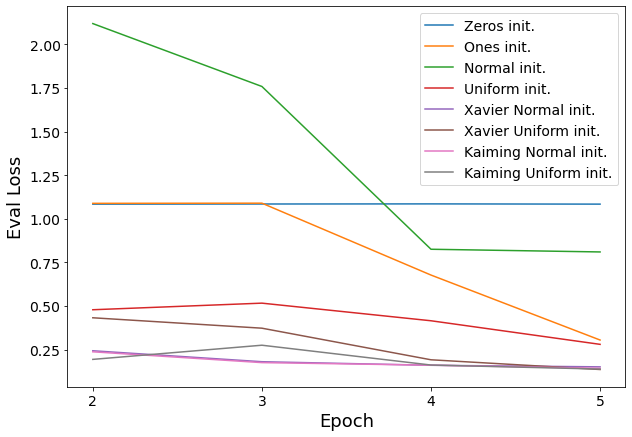

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 7))

epochs = list(range(1, NUM_EPOCHS+1))[1:]
plt.plot(epochs, zero_init_loss[1:], label='Zeros init.')
plt.plot(epochs, ones_init_loss[1:], label='Ones init.')
plt.plot(epochs, norm_init_loss[1:], label='Normal init.')
plt.plot(epochs, un_init_loss[1:], label='Uniform init.')

plt.plot(epochs, xn_init_loss[1:], label='Xavier Normal init.')
plt.plot(epochs, xu_init_loss[1:], label='Xavier Uniform init.')

plt.plot(epochs, hen_init_loss[1:], label='Kaiming Normal init.')
plt.plot(epochs, heu_init_loss[1:], label='Kaiming Uniform init.')

plt.xlabel('Epoch', fontsize=18)
plt.ylabel('Eval Loss', fontsize=18)
plt.xticks(epochs)

plt.xticks(fontsize=14)
plt.yticks(fontsize=14)

plt.legend(fontsize=14)